# Восстановление золота из руды

## Подготовка данных

In [4]:
#импортируем необходимые библиотеки и инструменты
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

In [5]:
#загрузим исходные данные, обучающую и тестовую выборки
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full_data = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [6]:
#ознакомимся с данными
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


В рамках подготовки данных нам необходимо проверить формулу вычисления эффективности обогащения. Формула выглядит так:

recovery = ((C * (F - T)) / (F * (C - T))) * 100%

где:

C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.
Основываясь на полученных от компании данных, необходимые нам признаки для проверки формулы это:

* rougher.output.concentrate_au (С)
* rougher.input.feed_au (F)
* rougher.output.tail_au (T)

А сам результат работы формулы находится здесь:

* rougher.output.recovery
Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака.

Создадим новый столбец с результатом вычисления эффективности обогащения по формуле.

In [7]:
#избавимся от пропусков в столбце rougher.output.recovery
train.dropna(subset = ['rougher.output.recovery'], inplace = True)

In [8]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

In [9]:
calculation = ((C * (F - T)) / (F * (C - T))) * 100

Построим гистограммы для двух наборов значений recovery - старого и нового.

In [10]:
old_recovery = train['rougher.output.recovery']

<AxesSubplot:>

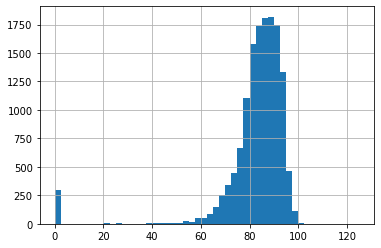

In [11]:
train['rougher.output.recovery'].hist(bins=50, range=(0, 125))

<AxesSubplot:>

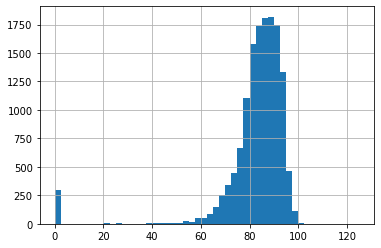

In [12]:
calculation.hist(bins=50, range=(0, 125))

На графиках нет различия в распределении старых и новых данных. Посчитаем MAE и посмотрим на среднее абсолютное отклонение.

In [13]:
print('MAE:', mean_absolute_error(old_recovery, calculation))

MAE: 9.73512347450521e-15


Среднее абсолютное отклонение очень мало. Различий между данными действительно нет, рассчеты верны.

Сравним наполнение обучающей и тестовой выборок.

In [14]:
print(train.shape)
print(test.shape)

(14149, 87)
(5290, 53)


В обущающей выборке признаков гораздо больше. Проанализируем те признаки, которые недоступны в тестовой выборке.

In [15]:
missing_cols = train.columns.drop(test.columns)
train[missing_cols].head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,8.547551,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,8.558743,...,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,8.603505,...,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,7.221879,...,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,9.089428,...,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448


По сути, все эти столбцы - целевые признаки (в зависимости от того, что именно мы предсказываем). Это концентрация различных веществ на выходе после отчистки, а также доля веществ в отвальных хвостах.

Выходит, у нас есть 53 признака (те, что в тестовой выборке) и 2 целевых признака, как по условию - rougher.output.recovery и final.output.recovery. Осталось убрать из обучающей выборки ненужные признаки и добавить целевые признаки в тестовую выборку.

In [16]:
cols_to_drop = missing_cols.drop(['final.output.recovery', 'rougher.output.recovery'])
right_cols = train.columns.drop(cols_to_drop)
train = train[right_cols]

Обучающая выборка готова, теперь займемся тестовой. Столбец date в исходных данных содержит уникальные значения. Будем использовать эти значения как индексы, чтобы объединить датасеты и добавить в тестовую выборку недостающую информацию.

In [17]:
target_features_to_join = full_data[['date', 'final.output.recovery', 'rougher.output.recovery']].copy()

In [18]:
test = test.join(target_features_to_join.set_index('date'), on='date')

In [19]:
train['final.output.recovery'].isnull().value_counts()

False    14149
Name: final.output.recovery, dtype: int64

In [20]:
test['final.output.recovery'].isnull().value_counts()

False    5290
Name: final.output.recovery, dtype: int64

На примере столбца final.output.recovery видим, что в обеих выборках есть отсутствующие данные. Избавимся от значений NaN в целевых признаках обеих выборок - такие данные не несут пользы.

In [21]:
train.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'], inplace = True)
test.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'], inplace = True)

In [22]:
test.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [23]:
print(train.shape)
print(test.shape)

(14149, 55)
(5290, 55)


Теперь у нас есть готовые обучающая и тестовая выборки, состоящие из необходимых столбцов и очищенные от наблюдений с пропусками в целевых признаках.

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [24]:
#подготовим датасет с необходимыми данными для золота
au_data = (full_data[[
    'rougher.input.feed_au', 
    'rougher.output.concentrate_au', 
    'primary_cleaner.output.concentrate_au', 
    'final.output.concentrate_au']].copy())

In [25]:
#серебра
ag_data = (full_data[[
    'rougher.input.feed_ag', 
    'rougher.output.concentrate_ag', 
    'primary_cleaner.output.concentrate_ag', 
    'final.output.concentrate_ag']].copy())

In [26]:
#свинца
pb_data = (full_data[[
    'rougher.input.feed_pb', 
    'rougher.output.concentrate_pb', 
    'primary_cleaner.output.concentrate_pb', 
    'final.output.concentrate_pb']].copy())

In [27]:
#напишем функцию, которая будет рисовать данные всех четырех столбцов на одном графике
def draw_hist (data, title):
    fig, ax = plt.subplots()
    ax.set_ylabel('Кол-во наблюдений')
    ax.set_xlabel('Концентрация металла')
    ax.set_title(title)
    for col in data:
        data[col].hist(alpha=.3) 
        ax.legend(['Исходное сырье','Флотация','Первичная очистка', 'Вторичная очистка'])

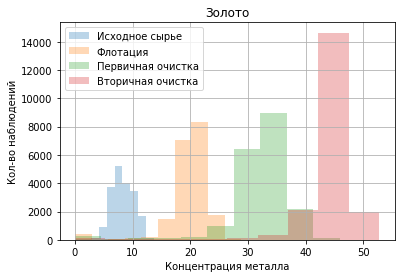

In [28]:
draw_hist(au_data, 'Золото')

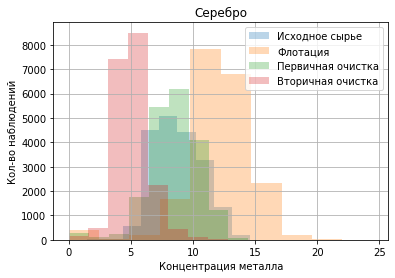

In [29]:
draw_hist(ag_data, 'Серебро')

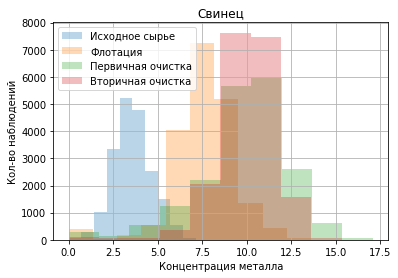

In [30]:
draw_hist(pb_data, 'Свинец')

По графикам можем определить следующее:

1.Для разных металлов концентрация на различных этапах очистки отличается. Например, концентрация золота увеличивается с каждым этапом. Концентрация серебра после вторичной очистки меньше, чем в исходном сырье. А у свинца результаты первичной и вторичной очистки почти идентичны.

2.В данных много нулевых значений. Скорее всего, для таких наблюдений не были сделаны замеры по какой-то причине, либо эти данные утрачены. Впоследствии нужно будет избавиться от таких данных, они могут повлиять на качество модели.

У нас есть два признака с параметром feed_size в обучающей и тестовой выборках - rougher.input.feed_size и primary_cleaner.input.feed_size. Сравним их распределения. Если они сильно отличаются друг от друга, оценка модели будет неправильной.

<AxesSubplot:>

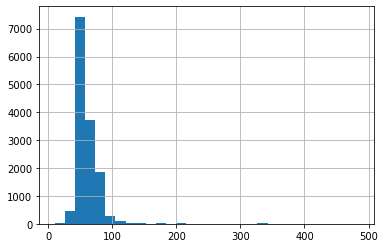

In [31]:
train['rougher.input.feed_size'].hist(bins=30)

<AxesSubplot:>

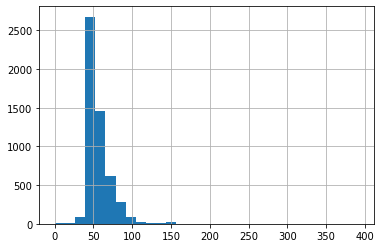

In [32]:
test['rougher.input.feed_size'].hist(bins=30)

<AxesSubplot:>

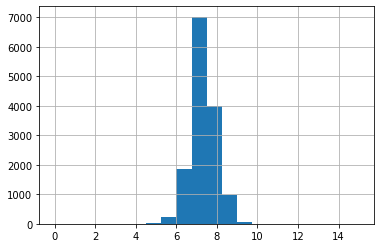

In [33]:
train['primary_cleaner.input.feed_size'].hist(bins=20, range=(0, 15))

<AxesSubplot:>

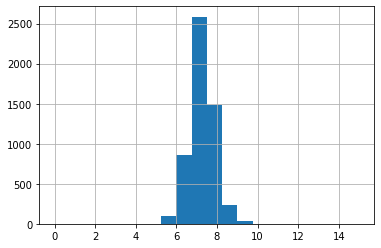

In [34]:
test['primary_cleaner.input.feed_size'].hist(bins=20, range=(0, 15))

Для обоих параметров распределения не сильно отличаются друг от друга, такие неточности не должны критично повлиять на работу модели.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [35]:
#создадим новый датасет с данныим о концентрации веществ и просуммируем их концентрацию на разных стадиях
concentrate_data = full_data[['date','rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']].copy()
concentrate_data['conc_sum_rougher'] = concentrate_data['rougher.input.feed_ag'] + concentrate_data['rougher.input.feed_pb'] + concentrate_data['rougher.input.feed_sol'] + concentrate_data['rougher.input.feed_au']
concentrate_data['conc_sum_primary'] = concentrate_data['primary_cleaner.output.concentrate_ag'] + concentrate_data['primary_cleaner.output.concentrate_pb'] + concentrate_data['primary_cleaner.output.concentrate_sol'] + concentrate_data['primary_cleaner.output.concentrate_au']
concentrate_data['conc_sum_final'] = concentrate_data['final.output.concentrate_ag'] + concentrate_data['final.output.concentrate_pb'] + concentrate_data['final.output.concentrate_sol'] + concentrate_data['final.output.concentrate_au']

<AxesSubplot:>

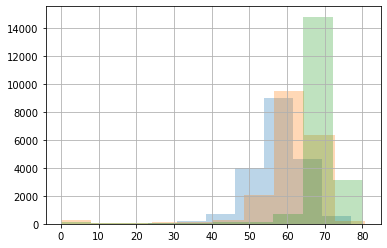

In [36]:
#построим гистограммы для суммарных концентраций веществ
concentrate_data['conc_sum_rougher'].hist(alpha=.3)
concentrate_data['conc_sum_primary'].hist(alpha=.3)
concentrate_data['conc_sum_final'].hist(alpha=.3)

По графикам видим, что в суммарных данных много нулевых или близких к нулю значений. Нужно избавиться от наблюдений с такими аномалиями, чтобы они не повлияли на качество модели.

In [37]:
#создадим датасет с аномальными наблюдениями
anomaly = (concentrate_data[['date', 'conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
           .copy()
           .query('conc_sum_rougher == 0 or conc_sum_primary == 0 or conc_sum_final == 0')
           .fillna(0))

In [38]:
anomaly.head()

,date,conc_sum_rougher,conc_sum_primary,conc_sum_final
19,2016-01-15 19:00:00,56.005644,0.0,64.546766
22,2016-01-15 22:00:00,56.038252,0.0,64.554911
30,2016-01-16 06:00:00,57.764677,0.0,63.765751
71,2016-01-18 01:00:00,56.626743,0.0,65.773298
74,2016-01-18 04:00:00,56.369424,0.0,59.902215


Избавимся от аномальных значений в тестовой выборке.

In [39]:
test = test.join(anomaly.set_index('date'), on='date')

In [40]:
test[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']] = (test[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']].fillna(-1))

In [41]:
test = test.query('conc_sum_rougher == -1 and conc_sum_primary == -1 and conc_sum_final == -1')

<AxesSubplot:>

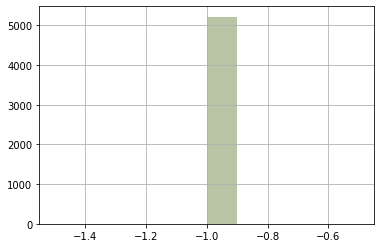

In [42]:
#проверим, что все выполнилось правильно - значением всех признаков должно быть -1
test['conc_sum_rougher'].hist(alpha=.2)
test['conc_sum_primary'].hist(alpha=.2)
test['conc_sum_final'].hist(alpha=.2)

In [43]:
#избавимся от ненужных столбцов
test.drop(['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final'], axis='columns', inplace=True)

Теперь удалим аномальные значения из обучающей выборки.

In [44]:
train = train.join(anomaly.set_index('date'), on='date')
train[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']] = (train[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
                                                                    .fillna(-1))
train = train.query('conc_sum_rougher == -1 and conc_sum_primary == -1 and conc_sum_final == -1')
train.drop(['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final'], axis='columns', inplace=True)

In [45]:
#удалим из выборок оставшиеся NaN-значения
test.dropna(inplace=True)
train.dropna(inplace=True)

In [46]:
print(train.shape)
print(test.shape)

(12593, 55)
(5169, 55)


Выборки готовы, можно строить модель.

## Модель

Напишем функцию для рассчета метрики качества модели - sMAPE

In [47]:
def smape (target, predictions):
    return 100/len(target) * np.sum(2 * np.abs(predictions - target) / (np.abs(target) + np.abs(predictions)))

А также функцию для рассчета итогового sMAPE.

In [48]:
def final_smape (rougher, final):
    return 0.25 * rougher + 0.75 * final

Подготовим features и target для обучающей выборки.

In [49]:
target_rougher = train['rougher.output.recovery']
target_final = train['final.output.recovery']

features_train = train.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis='columns')

Масштабируем признаки

In [50]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

Проверим несколько моделей методом кросс-валидации и выберем лучший результат.

In [51]:
model_dtr = DecisionTreeRegressor(random_state=12345)
cross_val_score(model_dtr, features_train, target_rougher, cv=3).mean()

-2.7627634627394144

In [52]:
model_lr = LinearRegression()
cross_val_score(model_lr, features_train, target_rougher, cv=3).mean()

-0.3487050264428386

In [53]:
model_cb = CatBoostRegressor(iterations=2, learning_rate=1, depth=3)
cross_val_score(model_cb, features_train, target_rougher, cv=3).mean()

0:	learn: 11.1329495	total: 55.7ms	remaining: 55.7ms
1:	learn: 10.4365891	total: 60.2ms	remaining: 0us
0:	learn: 10.1677055	total: 4.82ms	remaining: 4.82ms
1:	learn: 9.3328311	total: 8.8ms	remaining: 0us
0:	learn: 10.4213532	total: 13.4ms	remaining: 13.4ms
1:	learn: 10.1904997	total: 21.6ms	remaining: 0us


-0.2997732001069671

In [54]:
model_rf = RandomForestRegressor(random_state=12345, n_estimators=10)
cross_val_score(model_rf, features_train, target_rougher, cv=3).mean()

-0.7302685969382674

Лучший результат показывает модель CatBoost. Обучим её.

Подготовим features и target для тестовой выборки и масштабируем признаки.

In [55]:
target_rougher_test = test['rougher.output.recovery']
target_final_test = test['final.output.recovery']

features_test = test.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis='columns')

In [56]:
target_final_test, target_rougher_test

(0       70.273583
 1       68.910432
 2       68.143213
 3       67.776393
 4       61.467078
           ...    
 5285    68.919891
 5286    68.440582
 5287    67.092759
 5288    68.061186
 5289    71.699976
 Name: final.output.recovery, Length: 5169, dtype: float64,
 0       89.993421
 1       88.089657
 2       88.412756
 3       87.360133
 4       83.236367
           ...    
 5285    95.172585
 5286    94.575036
 5287    93.018138
 5288    92.599042
 5289    91.177695
 Name: rougher.output.recovery, Length: 5169, dtype: float64)

In [57]:
scaler = StandardScaler()
scaler.fit(features_test)
features_test = scaler.transform(features_test)

Обучим модель и получим предсказания.

In [58]:
model_cb = CatBoostRegressor(iterations=2, learning_rate=1, depth=3)
model_cb_1 = CatBoostRegressor(iterations=2, learning_rate=1, depth=3)

cb_rougher = model_cb.fit(features_train, target_rougher)
cb_final = model_cb_1.fit(features_train, target_final)

cb_predictions_rougher = cb_rougher.predict(features_test)
cb_predictions_final = cb_final.predict(features_test)

0:	learn: 11.0825737	total: 6.71ms	remaining: 6.71ms
1:	learn: 10.5202296	total: 13ms	remaining: 0us
0:	learn: 7.4506003	total: 8.3ms	remaining: 8.3ms
1:	learn: 7.1932438	total: 15.2ms	remaining: 0us


Посчитаем sMAPE для обоих признаков и итоговый.

In [59]:
smape_rougher = smape(target_rougher_test, cb_predictions_rougher)

In [60]:
smape_final = smape(target_final_test, cb_predictions_final)

In [61]:
final_smape(smape_rougher, smape_final)

8.94895448969088

Проверим качество модели, сравнив с константной. Для этого будем использовать модель DummyRegressor.

In [62]:
dummy = DummyRegressor(strategy = 'mean')
dummy_1 = DummyRegressor(strategy = 'mean')

dummy_rougher = dummy.fit(features_train, target_rougher)
dummy_predictions_rougher = dummy_rougher.predict(features_test)

dummy_final = dummy_1.fit(features_train, target_final)
dummy_predictions_final = dummy_final.predict(features_test)

In [63]:
smape_rougher_dummy = smape(target_rougher_test, dummy_predictions_rougher)

In [64]:
smape_final_dummy = smape(target_final_test, dummy_predictions_final)

In [65]:
final_smape(smape_rougher_dummy, smape_final_dummy)

8.873662390741785

Обученная модель предсказывает результат точнее константной. Это говорит о том, что построенная модель адекватна.

# Вывод
Наилучшей моделью является CatBoostRegressor.

Написали функции для рассчета sMAPE и итогового sMAPE.

Проверили несколько формул кросс-валидацией.

Проверили работу модели на тестовой выборке с помощью метрики качества sMAPE и сравнения с константной 
моделью.

Подготовили прототип модели машинного обучения для «Цифры».